# Day 15 主成分分析(principal component analysis，PCA)
CA 是一种快速灵活的数据降维无监督方法,尤其适用于数据可视化、噪音过滤、特征抽取和特征工程等领域

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


# warnings.filterwarnings(action='ignore')

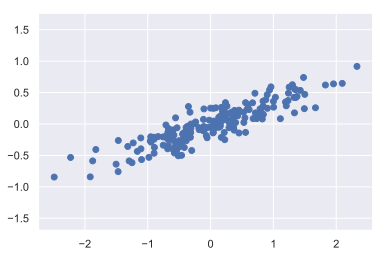

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

在主成分分析中，一种量化两变量间关系的方法是在数据中找到一组主轴，并用这些主轴 来描述数据集

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

该拟合从数据中学习到了一些指标，其中最重要的是“成分”和“可解释差异”:

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


为了查看这些数字的含义，在数据图上将这些指标以向量形式画出来，用“成分”定义向 量的方向，将“可解释差异”作为向量的平方长度

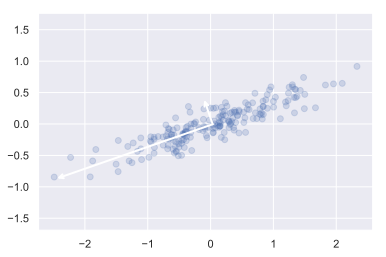

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# 画出数据
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

这些向量表示数据主轴, 箭头长度表示输入数据中各个轴的“重要程度”——更准确地说，它衡量了数据投影到主轴上的方差的大小。每个数据点在主轴上的投影就是数据的“主成分”。

## 1. 用PCA降维
用 PCA 降维意味着去除一个或多个最小主成分，从而得到一个更低维度且保留最大数据方差的数据投影

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


变换的数据被投影到一个单一维度。为了理解降维的效果，我们来进行数据降维的逆变 换，并且与原始数据一起画出:

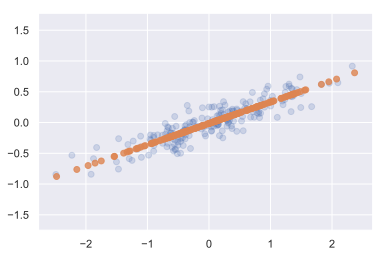

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

浅色的点是原始数据，深色的点是投影的版本.我们可以很清楚地看到 PCA 降维的含义: 
<hr>**沿着最不重要的主轴的信息都被去除了，仅留下了含有最高方差值的数据成分。被去除的那一小部分方差值(与主轴上分布的点成比例)基本可以看成是数据在降 维后损失的“信息”量。**
<br>这种降维后的数据集在某种程度上足以体现数据中最主要的关系:虽然有 50% 的数据维度 被削减，但数据的总体关系仍然被大致保留了下来。


## 2. 用PCA作数据可视化:手写数字
降维的有用之处在数据仅有两个维度时可能不是很明显，但是当数据维度很高时，它的价值就有所体现了。

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape
# 64维是因为 8 像素 ×8 像素的图像

(1797, 64)

为了获得这些 数据点间关系的直观感受，使用 PCA 将这些数据投影到一个可操作的维度，比如说二维:

In [10]:
pca = PCA(2) # 从64维投影至二维
projected = pca.fit_transform(digits.data)
print('new data shape:', projected.shape)

new data shape: (1797, 2)


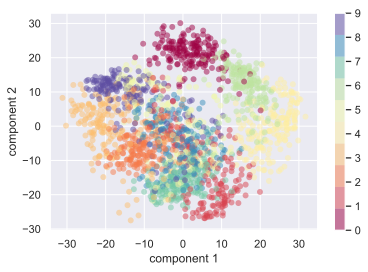

In [11]:
plt.scatter(projected[:, 0], projected[:, 1], c=digits.target, 
            edgecolor='none', alpha=0.5, 
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## 3. 成分的含义

削减的维度有什么含义?可以从基向量的组合角度来理解这个 问题。例如，训练集中的每幅图像都是由一组 64 像素值的集合定义的，将称其为向量 x: $$x = [x1, x2, x3 ... x64]$$

为了构建一幅图像，将向量的每个元素与对应描述的像素(单位列向量)相乘，然后将这些结果加和就是这副图像:
$$image(x)= x1· (pixel 1)+ x2· (pixel 2)+ x3· (pixel 3)...x64· (pixel 64)$$
可以将数据的降维理解为删除绝大部分元素，仅保留少量元素的基向量(basis vector)

**PCA 可以被认为是选择最优基函数的过程，这样将这些基函数中前几个加起来就足以重构数据集中的大部分元素.
<br>其原理为它能发现一组比原始的像素基向量更能有效表示输入数据的基函数。**

## 4. 选择成分的数量

实际使用 PCA 的过程中，正确估计用于描述数据的成分的数量是非常重要的环节。我们可以将**累计方差贡献率**看作是关于成分数量的函数，从而确定所需成分的数量:

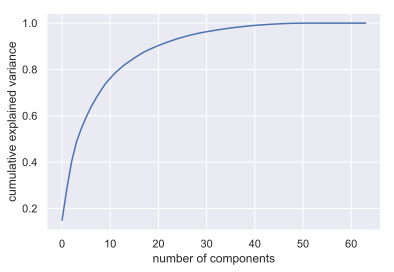

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

这个曲线量化了在前 N 个主成份中包含了多少总的 64 维的方差
<br>例如，可以看到前 10 个 成分包含了几乎 75% 的方差。因此，如果你希望描述接近 100% 的方差，那么就需要大约 50 个成分。

由图可知，对于该数据, 二维的投影会损失很多信息(正如解释方差所表示的)。我们需要大约 20 个成 分来保持 90% 的方差

## 4.用PCA作噪音过滤

PCA 也可以被用作噪音数据的过滤方法——任何成分的方差都远大于噪音的方差 <font color='red'>(不该是小于?)</font>( any components with variance much larger than the effect of the noise should be relatively unaffected by the noise)，所以相 比于噪音，成分应该相对不受影响。

画出几个无噪音的输入数据:

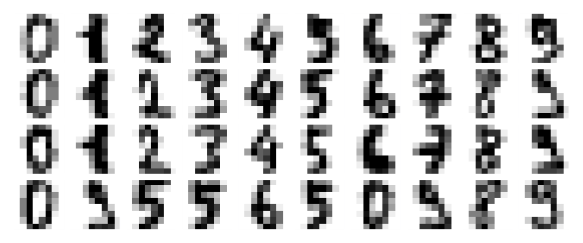

In [13]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

现在添加一些随机噪音并创建一个噪音数据集，重新画图:

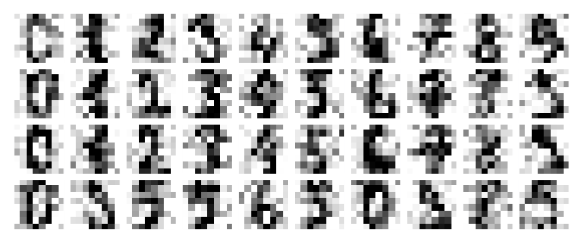

In [14]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

可以很清楚地看到图像是带噪音的，也包含错误的像素。用噪音数据训练一个 PCA，要求投影后保存 50% 的方差

In [15]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

这里 50% 的方差对应 12 个主成份。现在来计算出这些成分，然后利用逆变换重构过滤后的手写数字

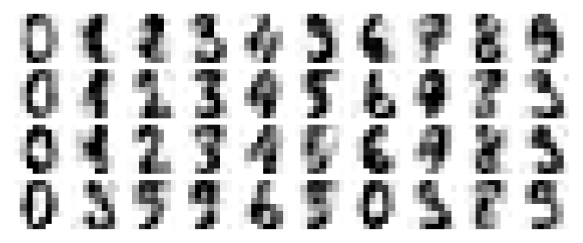

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered) # 厉害啊!

这个信号保留 / 噪音过滤的性质使 PCA 成为一种非常有用的特征选择方式。例如，与其在 很高维的数据上训练分类器，你可以选择在一个低维表示中训练分类器，该分类器将自动 过滤输入数据中的随机噪音。